In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
import nltk
import sys
%matplotlib inline

In [2]:
data_path = "./data/Digital_Music_5.json"
table = pd.read_json(data_path, 'records', lines = True).reset_index(drop = True, inplace = False)
print(table.head())

       reviewerID        asin          reviewerName helpful  \
0  A3EBHHCZO6V2A4  5555991584  Amaranth "music fan"  [3, 3]   
1   AZPWAXJG9OJXV  5555991584             bethtexas  [0, 0]   
2  A38IRL0X2T4DPF  5555991584           bob turnley  [2, 2]   
3  A22IK3I6U76GX0  5555991584                 Calle  [1, 1]   
4  A1AISPOIIHTHXX  5555991584           Cloud "..."  [1, 1]   

                                          reviewText  overall  \
0  It's hard to believe "Memory of Trees" came ou...        5   
1  A clasically-styled and introverted album, Mem...        5   
2  I never thought Enya would reach the sublime h...        5   
3  This is the third review of an irish album I w...        5   
4  Enya, despite being a successful recording art...        4   

                        summary  unixReviewTime   reviewTime  
0       Enya's last great album      1158019200  09 12, 2006  
1      Enya at her most elegant       991526400   06 3, 2001  
2               The best so far      1058

In [3]:
table.shape

(64706, 9)

In [4]:
table.describe()['overall'].T

count    64706.000000
mean         4.222514
std          1.086081
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [5]:
print('Number of missing values across columns: \n',table.isnull().sum())

Number of missing values across columns: 
 reviewerID          0
asin                0
reviewerName      177
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64


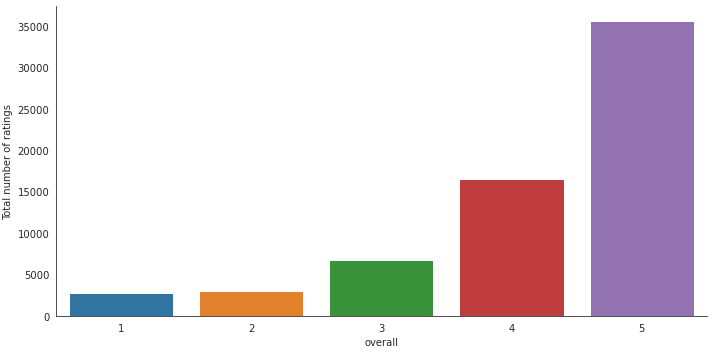

In [6]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=table, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [7]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",table.shape[0])
print("Total No of Users   :", len(np.unique(table.reviewerID)))
print("Total No of products  :", len(np.unique(table.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 64706
Total No of Users   : 5541
Total No of products  : 3568


In [8]:
table.drop(['reviewerName'], axis=1,inplace=True)
table.drop(['helpful'], axis=1,inplace=True)
table.drop(['reviewText'], axis=1,inplace=True)
table.drop(['summary'], axis=1,inplace=True)
table.drop(['unixReviewTime'], axis=1,inplace=True)
table.drop(['reviewTime'], axis=1,inplace=True)

In [9]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = table.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A9Q28YTLYREO7     578
A3HU0B9XUEVHIM    375
A3KJ6JAZPH382D    301
A3C6ZCBUNXUT7V    261
A8IFUOL8S9BZC     256
Name: overall, dtype: int64

In [10]:
no_of_rated_products_per_user.describe()

count    5541.000000
mean       11.677676
std        18.222800
min         5.000000
25%         5.000000
50%         7.000000
75%        11.000000
max       578.000000
Name: overall, dtype: float64

In [11]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

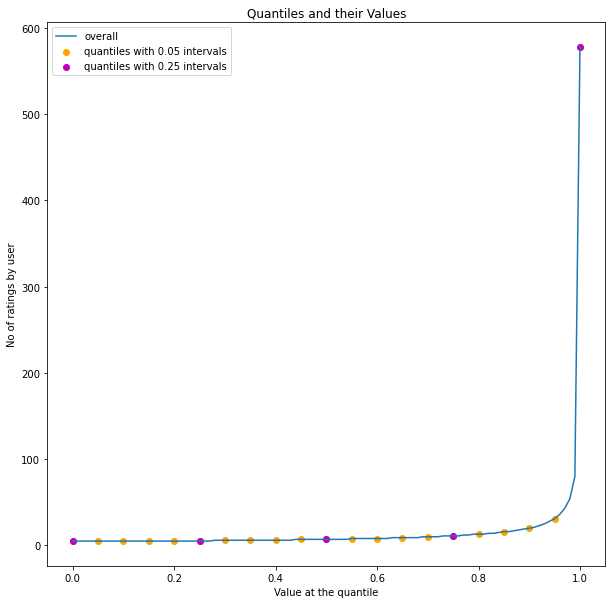

In [12]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [13]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 126



In [14]:
##Popularity Based Recommendation

#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=table.groupby("asin").filter(lambda x:x['overall'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, '')]

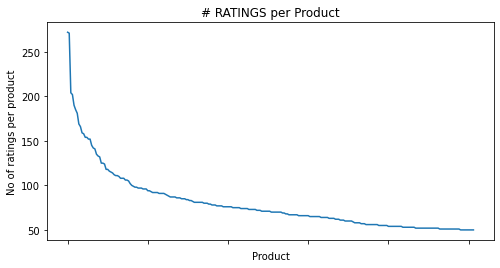

In [15]:
no_of_ratings_per_product = new_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [16]:
#Average rating of the product 

new_df.groupby('asin')['overall'].mean().head()

asin
B00000016W    4.629630
B00000064G    4.734177
B000000OUJ    4.835443
B000000TDH    4.518519
B0000013GH    4.450980
Name: overall, dtype: float64

In [17]:
new_df.groupby('asin')['overall'].mean().sort_values(ascending=False).head()

asin
B000002WR5    4.924242
B000028U0Y    4.920000
B00003002C    4.890110
B000001A6N    4.884615
B000003AEK    4.882353
Name: overall, dtype: float64

In [18]:
#Total no of rating for product

new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B0007NFL18    272
B000084T18    271
B00006690F    204
B00004T9UF    202
B00005YW4H    190
Name: overall, dtype: int64

In [19]:
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['overall'].mean())

In [20]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())

In [21]:
ratings_mean_count.head()

,overall,rating_counts
asin,,
B00000016W,4.629630,135
B00000064G,4.734177,79
B000000OUJ,4.835443,79
B000000TDH,4.518519,54
B0000013GH,4.450980,51


In [22]:
ratings_mean_count['rating_counts'].max()

272

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

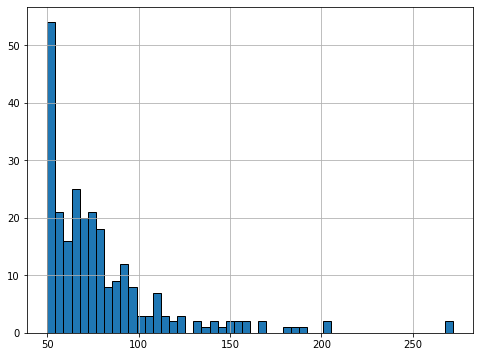

In [23]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

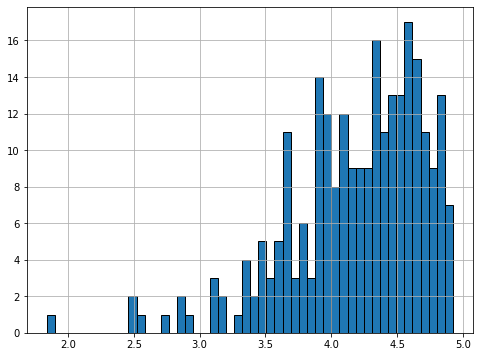

In [24]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['overall'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

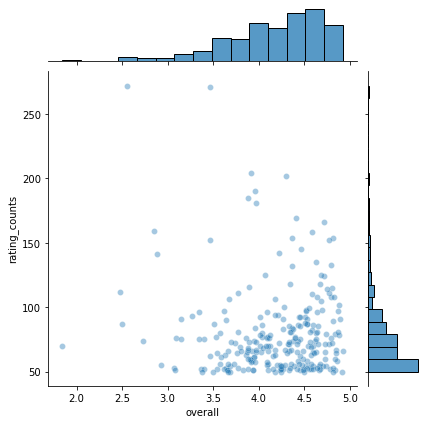

In [25]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='asin'>

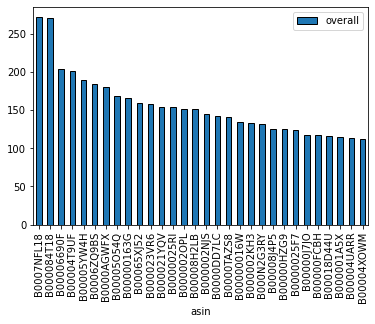

In [26]:
popular_products = pd.DataFrame(new_df.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [27]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [28]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
cols = new_df.columns.tolist()
df = new_df[cols] 
# df = df._convert(numeric=True)
print(df)
# print(df.dtypes)
# df['asin']=df['asin'].astype(np.float64)
# print(df.dtypes)

data = Dataset.load_from_df(df,reader)

           reviewerID        asin  overall
85     A1C0C9IJO2HS03  B00000016W        5
86     A22N9H8V0RYQR3  B00000016W        1
87     A1E110L9ZKX6FD  B00000016W        5
88     A3HU0B9XUEVHIM  B00000016W        5
89     A252HNVAZENVNE  B00000016W        5
...               ...         ...      ...
61354  A2X4WHLXULSKDD  B005QJZ5FA        5
61355   AY6A8KPYCE6B0  B005QJZ5FA        4
61356  A2U3XA8QL4IPJO  B005QJZ5FA        5
61357   AFEN54UGJQOK9  B005QJZ5FA        5
61358  A13Y1WNMYX93EL  B005QJZ5FA        5

[20271 rows x 3 columns]


In [29]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.2,random_state=0)

In [30]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [31]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [32]:
test_pred

[Prediction(uid='AJQMDNJRZP6MD', iid='B00005NHJS', r_ui=5.0, est=4.188888888888888, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2QMBY3CCR2B02', iid='B0006ZQ9BS', r_ui=5.0, est=3.526872775014084, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A26XCS3QLDJJWN', iid='B000035X1M', r_ui=4.0, est=4.495448363046333, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A1Q6KVOLE0HO3R', iid='B000002KZR', r_ui=5.0, est=4.966816330920197, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1S7N1XX196ON7', iid='B0000TAZS8', r_ui=4.0, est=1.3634967355708156, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1ALPL858XSDE', iid='B0001XANAS', r_ui=5.0, est=4.168413912185496, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQZE4MMQMDKPB', iid='B0000039QA', r_ui=5.0, est=4.794003657440352, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A23F0RW

In [33]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0726


1.0725899236541012

In [34]:
#Model-based collaborative filtering system

ratings_matrix = new_df.pivot_table(values='overall', index='reviewerID', columns='asin', fill_value=0)
ratings_matrix.head()

asin,B00000016W,B00000064G,B000000OUJ,B000000TDH,B0000013GH,B0000013GT,B00000163G,B000001A5X,B000001A6N,B000001A6X,...,B0029LHW4U,B002DSM8UC,B002GZQYMA,B003KUSUG8,B003V5PPZG,B003WTE886,B004D1GZ2E,B004K4AUZW,B004NSULHM,B005QJZ5FA
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1020L7BWW9RAX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10323WWTFPSGP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A103KNDW8GN92L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A103W7ZPKGOCC9,0,0,0,0,0,0,0,5,0,5,...,0,0,0,0,0,0,0,0,0,0
A105S56ODHGJEK,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
ratings_matrix.shape

(4509, 254)

In [36]:
X = ratings_matrix.T
X.head()

reviewerID,A1020L7BWW9RAX,A10323WWTFPSGP,A103KNDW8GN92L,A103W7ZPKGOCC9,A105S56ODHGJEK,A1065Q31DNPRAN,A106BECWWKQIC9,A107R79K63CE30,A10872FHIJAKKD,A109WIE49N0GV,...,AZPWAXJG9OJXV,AZSN1TO0JI87B,AZT9OGZODW8VW,AZTVHB938DIG5,AZTZ61W23JET0,AZVA13Q19KURR,AZVH70JMJ2IHX,AZWCAUCNLGL4H,AZY3MDFJJFI91,AZYZA8FDL48GD
asin,,,,,,,,,,,,,,,,,,,,,
B00000016W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000064G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000000OUJ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000000TDH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000013GH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X1 = X

In [38]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(254, 10)

In [39]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(254, 254)

In [40]:
X.index[253]

'B005QJZ5FA'

In [41]:
i = "B005QJZ5FA"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

253

In [42]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(254,)

In [43]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['B000000TDH',
 'B000001DZO',
 'B0000025WQ',
 'B0000029DD',
 'B000002J2S',
 'B000002VN7',
 'B000002VT6',
 'B000006045',
 'B00000D9TQ',
 'B00000IAU3',
 'B00001QGQI',
 'B00004Z41Q',
 'B000059MEK',
 'B00005K9KP',
 'B00005M987',
 'B00005NZDW',
 'B00005QDVS',
 'B00005TPKC',
 'B00005YW4H',
 'B0000646TK',
 'B00006L7XQ',
 'B00007KK7V',
 'B000089CJI',
 'B000089RVR']